In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('predict_model_raw_data.csv')

# data[['pos','neg','neu']] = data[['pos','neg','neu']].diff()

# 滑动窗口
window_size = 7 # 窗口大小
data[['pos','neg','neu']] = data[['pos','neg','neu']].rolling(window_size).mean()

scaler = MinMaxScaler()
data[['pos','neg','neu']]= scaler.fit_transform(data[['pos','neg','neu']])
data[['pos','neg','neu']] = data[['pos','neg','neu']].pct_change()
# data['label'] = data['Close'].diff()
# data = data[data['label'].notna()]
# data['label'] = data['label'].map(lambda x: 1 if x > 0 else 0)
data['label'] = data['Close']
data[['label']]= scaler.fit_transform(data[['label']])
data['label'] = data['label'].pct_change()
# lag 一天
# data[['pos','neg','neu']] = data[['pos','neg','neu']].shift(1)

start = '2020-01-01'
end = '2023-05-31'
data['date'] = pd.to_datetime(data['date'])
data = data[(data['date']>= pd.Timestamp(start)) & (data['date'] <= pd.Timestamp(end))]
# 构造特征
features = data[['pos', 'neg', 'neu']]
labels = data['label']
date = data['date']
# 假设数据集X为特征矩阵，y为目标变量
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = features.iloc[:999]
y_train = labels.iloc[:999]

X_test = features.iloc[1000:]
y_test = labels.iloc[1000:]


In [120]:
from sklearn.metrics import mean_squared_error
import numpy as np
model = xgboost.XGBRegressor(max_depth=50, learning_rate=0.1, n_estimators=100, objective='reg:gamma')
model.fit(X_train, y_train)

aaa = model.predict(X_train)


ans = model.predict(X_test)
ans
rmse = np.sqrt(mean_squared_error(ans, y_test))
print('RMSE:', rmse)

RMSE: 0.13513370571585798


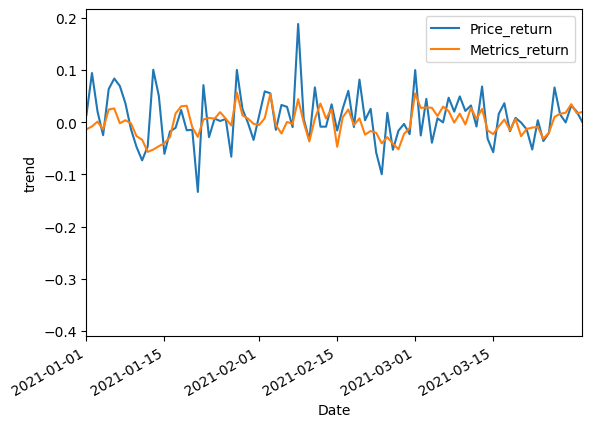

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# plt.figure(figsize=(60, 20))
plt.plot(data['date'], data['label'],label='Price_return')
plt.plot(data['date'], data['pos'],label='Metrics_return')
# plt.plot(sen_dates, trend,label='Sentiment_return')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('trend')
# plt.title(start+'~'+end)
# plt.ylim(-0.2,0.2)
start = '2021-01-01'
end = '2021-03-31'
plt.xlim(pd.Timestamp(start), pd.Timestamp(end))

plt.legend()
plt.show()

In [59]:
# 定义模型参数
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',  # 二分类任务
    'eval_metric': 'logloss',         # 评估指标为logloss，在训练过程中输出
    'eta': 0.1,                       # 学习率，控制每次迭代的步长，默认为0.3
    'max_depth': 3,                   # 决策树最大深度
    'min_child_weight': 1,            # 叶子节点的最小权重
    'gamma': 0.1,                     # 节点分裂时损失函数的下降阈值
    'subsample': 0.8,                 # 每棵树随机采样的比例
    'colsample_bytree': 0.8,          # 每棵树进行特征采样的比例
    'reg_alpha': 0.01,                # L1正则化系数
    'reg_lambda': 0.01,               # L2正则化系数
    'seed': 42                        # 随机种子，保证结果可复现
}

# params = {
#     'booster': 'gbtree',
#     'objective': 'binary:logistic',  # 二分类任务
#     'eval_metric': 'logloss',         # 评估指标为logloss，在训练过程中输出
# }
# 将数据转换为DMatrix格式，优化XGBoost性能
dtrain = xgboost.DMatrix(X_train, label=y_train)

# 训练模型
model = xgboost.train(params=params, dtrain=dtrain, num_boost_round=100)


Accuracy: 72.39%


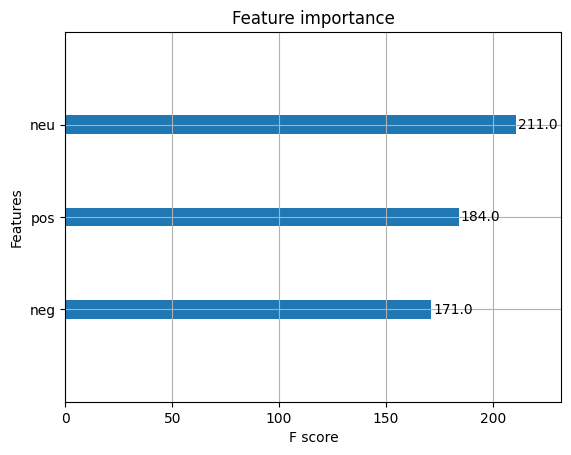

In [60]:
# 将测试集转换为DMatrix格式
dtest = xgboost.DMatrix(X_test)

# 在测试集上预测
y_pred = model.predict(dtest)

# 将预测结果转换为0-1二分类
y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()
